<a href="https://colab.research.google.com/github/VictorMadu/Stackover-question-tagging/blob/master/Data%20Processing%20and%20Feature%20Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
 import nltk
nltk.download('punkt')
nltk.download('stopwords')
! pip install scikit-multilearn 
!pip install "tensorflow_hub>=0.6.0"
!pip install "tensorflow>=2.0.0"

import tensorflow as tf
import tensorflow_hub as hub

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 92kB 4.4MB/s 
     |████████████████████████████████| 421.8MB 38kB/s 
     |████████████████████████████████| 3.9MB 45.7MB/s 
     |████████████████████████████████| 450kB 50.2MB/s 
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tens

In [0]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
import io
import shutil
from zipfile import ZipFile
from sqlalchemy import create_engine
import datetime
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn import svm
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

Due to limited computation power, storage and time taken to run code, i will use 1000000 samples of data to train my model


In [0]:
with ZipFile('/content/drive/My Drive/facebook-recruiting-iii-keyword-extraction.zip', 'r') as zf: 
  zf.printdir() 

  # extracting all the files 
  print('Extracting all the files now...') 
  zf.extractall() 
  print('Done!') 


with ZipFile('/content/Train.zip') as zf:
  zf.printdir()

  # extracting .csv file from Train.zip
  print('Extracting the .csv file now...')
  zf.extractall()
  print('Done!')

File Name                                             Modified             Size
SampleSubmission.csv                           2019-12-11 23:27:44     82546830
Test.zip                                       2019-12-11 23:27:54    760327055
Train.zip                                      2019-12-11 23:29:10   2347110159
Extracting all the files now...
Done!
File Name                                             Modified             Size
Train.csv                                      2013-07-22 14:50:22   7253917400
Extracting the .csv file now...
Done!


In [0]:
df = pd.read_csv('Train.csv')

In [0]:
df = df.sample(1200000)
df.iloc[1000000:].to_csv('test.csv')

In [0]:
df = df[:1000000]
df.Id = np.arange(len(df))

In [0]:
df.head()

,Id,Title,Body,Tags
529147,0,Gratuitous ARP request using C#,<p>Working on a Windows 2008 server and assign...,c# .net windows network-programming arp
264565,1,How to correctly wrap richfaces panel inside a...,<p>I tried to write in resources/ui/div.xhtml:...,jsf-2 composite-component
884650,2,Can I have form tag inside View in MVC?,<p>Can we put form tag inside view in MVC. I n...,asp.net-mvc
4896727,3,LyX : Inline completion in math mode,<p>I was wondering if the following feature ex...,math-mode lyx auto-completion
2567932,4,"when download an image, does urllib have a ret...",<p>I want to download an image file from poten...,python


In [0]:
tags = df['Tags']

In [0]:
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(tags.apply(lambda x: np.str_(x)))

In [0]:
print('The number of data points is:', multilabel_y.shape[0])
print('The number of unique tags is:', multilabel_y.shape[1])

The number of data points is: 1000000
The number of unique tags is: 34950


In [0]:
def tags_to_choose(n):
  t = multilabel_y.sum(axis=0).tolist()[0]
  sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
  multilabel_yn = multilabel_y[:,sorted_tags_i[:n]]
  return multilabel_yn

def questions_explained_fn(n):
  multilabel_yn = tags_to_choose(n)
  x = multilabel_yn.sum(axis=1)
  return (np.count_nonzero(x==0))


In [0]:
questions_explained = []
total_tags = multilabel_y.shape[1]
total_qs = df.shape[0]
for i in range(500, total_tags, 100):
  questions_explained.append(np.round((total_qs-questions_explained_fn(i))))

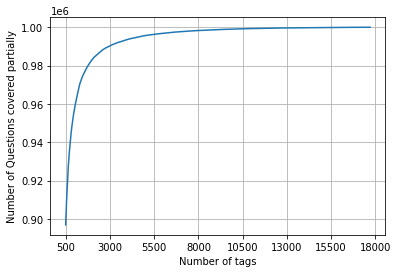

In [0]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel('Number of tags')
plt.ylabel('Number of Questions covered partially')
plt.grid()
plt.show()


In [0]:
vectorizer = CountVectorizer(tokenizer=lambda x:x.split(), binary='true', max_features=5500)
multilabel_y = vectorizer.fit_transform(df['Tags'].apply(np.str_))

In [0]:
print('The number of data points is:', multilabel_y.shape[0])
print('The number of unique tags is:', multilabel_y.shape[1])

The number of data points is: 1000000
The number of unique tags is: 5500


In [0]:
def striphtml(data):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, " ", str(data))
  return cleantext

In [0]:
module_url = "https://tfhub.dev/google/nnlm-en-dim128/2"
embed = hub.KerasLayer(module_url)

In [0]:
def adapt_array(arr):
  out = io.BytesIO()
  np.save(out, arr)
  out.seek(0)
  return sqlite3.Binary(out.read())

def convert_array(text):
  out = io.BytesIO(text)
  out.seek(0)
  return np.load(out)


# Converts np.array to TEXT when inserting
sqlite3.register_adapter(np.ndarray, adapt_array)

# Converts TEXT to np.array when selecting
sqlite3.register_converter("array", convert_array)


conn = sqlite3.connect("Question.sqlite",  detect_types=sqlite3.PARSE_DECLTYPES)
conn.execute("""CREATE TABLE IF NOT EXISTS data(Id INTEGER, title_vec array, question_vec array, code_vec array, len_title INTEGER, len_question INTEGER,  tags TEXT);""")

In [0]:
conn = sqlite3.connect("Question.sqlite")
start = datetime.now()
preprocessed_data_list = []
questions_with_code = 0
questions_processed = 0


for row in df.iterrows():
    Id, title, question, tags =  row[1]['Id'], row[1]['Title'], row[1]['Body'], row[1]['Tags']

    if '<code>' in question:
      questions_with_code += 1
      

      code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
      code = np.array(embed([code]))
    else: 
      code = np.zeros((1,128))

    question = re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question = striphtml(question.encode('utf-8'))
    question = np.array(embed([question]))

    title = title.encode('utf-8')
    title = np.array(embed([title]))


    tup  = (Id, title, question, code, len(title), len(question),  tags)
    conn.execute("""INSERT INTO data VALUES(?, ?, ?, ?, ?, ?, ?)""", tup)
    questions_processed += 1

    if (questions_processed%50000==0):
      print('number of questions completed=', questions_processed)
    
conn.commit()

print('Time taken to run this cell:', datetime.now()-start)

number of questions completed= 50000
number of questions completed= 100000
number of questions completed= 150000
number of questions completed= 200000
number of questions completed= 250000
number of questions completed= 300000
number of questions completed= 350000
number of questions completed= 400000
number of questions completed= 450000
number of questions completed= 500000
number of questions completed= 550000
number of questions completed= 600000
number of questions completed= 650000
number of questions completed= 700000
number of questions completed= 750000
number of questions completed= 800000
number of questions completed= 850000
number of questions completed= 900000
number of questions completed= 950000
number of questions completed= 1000000
Time taken to run this cell: 0:44:47.362880


In [0]:
shutil.move('/content/Question.sqlite', '/content/drive/My Drive')

In [0]:
import dill
dill.dump(vectorizer, open('tag_vectorizer.p', 'wb'))